In [7]:
## Standard libraries
import os
import numpy as np
import random
from PIL import Image
from types import SimpleNamespace

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

## PyTorch
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms

/var/folders/sh/1qclfzm54zlgld8yp8_l0bbh0000gn/T/ipykernel_64038/4060246365.py:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


In [8]:
# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial5"

# Function for setting the seed
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
set_seed(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using device {device}")

Using device cpu


In [9]:
import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial5/"
# Files to download
pretrained_files = ["GoogleNet.ckpt", "ResNet.ckpt", "ResNetPreAct.ckpt", "DenseNet.ckpt",
                    "tensorboards/GoogleNet/events.out.tfevents.googlenet",
                    "tensorboards/ResNet/events.out.tfevents.resnet",
                    "tensorboards/ResNetPreAct/events.out.tfevents.resnetpreact",
                    "tensorboards/DenseNet/events.out.tfevents.densenet"]
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if "/" in file_name:
        os.makedirs(file_path.rsplit("/",1)[0], exist_ok=True)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)


In [10]:
train_dataset = CIFAR10(root=DATASET_PATH, train=True, download=True)

# will use the mean and std info to normalize the data
DATA_MEANS = (train_dataset.data/255.0).mean(axis=(0,1,2))
DATA_STD = (train_dataset.data/255.0).std(axis=(0,1,2))
print("Data mean", DATA_MEANS)
print("Data std", DATA_STD)

Files already downloaded and verified
Data mean [0.49139968 0.48215841 0.44653091]
Data std [0.24703223 0.24348513 0.26158784]


In [11]:
# apply data augmentation to training to prevent overfitting and improve generalizability

test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(DATA_MEANS, DATA_STD)
                                     ])
# For training, we add some augmentation. Networks are too powerful and would overfit.
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomResizedCrop((32,32),scale=(0.8,1.0),ratio=(0.9,1.1)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(DATA_MEANS, DATA_STD)
                                     ])
# Loading the training dataset. We need to split it into a training and validation part
# We need to do a little trick because the validation set should not use the augmentation.
train_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=train_transform, download=True)
val_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=test_transform, download=True)
set_seed(42)
train_set, _ = torch.utils.data.random_split(train_dataset, [45000, 5000])
set_seed(42)
_, val_set = torch.utils.data.random_split(val_dataset, [45000, 5000])

# Loading the test set
test_set = CIFAR10(root=DATASET_PATH, train=False, transform=test_transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
train_loader = data.DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
val_loader = data.DataLoader(val_set, batch_size=128, shuffle=False, drop_last=False, num_workers=4)
test_loader = data.DataLoader(test_set, batch_size=128, shuffle=False, drop_last=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [19]:
# validate that after the transforms, mean ~ 0 and std ~ 1
if False:
    imgs, _ = next(iter(train_loader))
    print("Batch mean", imgs.mean(dim=[0,2,3]))
    print("Batch std", imgs.std(dim=[0,2,3]))

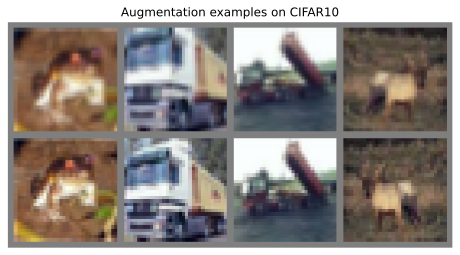

In [13]:
# visualize images to see what data augmentation did
NUM_IMAGES = 4
images = [train_dataset[idx][0] for idx in range(NUM_IMAGES)]
orig_images = [Image.fromarray(train_dataset.data[idx]) for idx in range(NUM_IMAGES)]
orig_images = [test_transform(img) for img in orig_images]

img_grid = torchvision.utils.make_grid(torch.stack(images + orig_images, dim=0), nrow=4, normalize=True, pad_value=0.5)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("Augmentation examples on CIFAR10")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

### PyTorch Lightning
PyTorch Lightning is a framework that simplifies your code needed to train, evaluate, and test a model in PyTorch. It also handles logging into TensorBoard, a visualization toolkit for ML experiments, and saving model checkpoints automatically with minimal code overhead from our side.

In [14]:
# PyTorch Lightning
import pytorch_lightning as pl
pl.seed_everything(42) # don't need to define our own set seed function anymore

Global seed set to 42


42

In PyTorch Lightning, we define `pl.LightningModule`’s (inheriting from `torch.nn.Module`) that organize our code into 5 main sections:

1. Initialization (`__init__`), where we create all necessary parameters/models

2. Optimizers (`configure_optimizers`) where we create the optimizers, learning rate scheduler, etc.

3. Training loop (`training_step`) where we only have to define the loss calculation for a single batch (the loop of `optimizer.zero_grad()`), `loss.backward()` and `optimizer.step()`, as well as any logging/saving operation, is done in the background)

4. Validation loop (`validation_step`) where similarly to the training, we only have to define what should happen per step

5. Test loop (`test_step`) which is the same as validation, only on a test set.


In [15]:
class CIFARModule(pl.LightningModule):
    def __init__(self, model_name, model_hparams, optimizer_name, optimizer_hparams):
        """
        Inputs:
            model_name - Name of the model/CNN to run. Used for creating the model (see function below)
            model_hparams - Hyperparameters for the model, as dictionary.
            optimizer_name - Name of the optimizer to use. Currently supported: Adam, SGD
            optimizer_hparams - Hyperparameters for the optimizer, as dictionary. This includes learning rate, weight decay, etc.
        """
        super().__init__()
        # Exports the hyperparameters to a YAML file, and create "self.hparams" namespace
        self.save_hyperparameters()
        # Create model
        self.model = create_model(model_name, model_hparams)
        # Create loss module
        self.loss_module = nn.CrossEntropyLoss()
        # Example input for visualizing the graph in Tensorboard
        self.example_input_array = torch.zeros((1, 3, 32, 32), dtype=torch.float32)

    def forward(self, imgs):
        return self.model(imgs)

    def configure_optimizers(self):
        # We will support Adam or SGD as optimizers.
        if self.hparams.optimizer_name == "Adam":
            # AdamW is Adam with a correct implementation of weight decay (see here for details: https://arxiv.org/pdf/1711.05101.pdf)
            optimizer = optim.AdamW(
                self.parameters(), **self.hparams.optimizer_hparams)
        elif self.hparams.optimizer_name == "SGD":
            optimizer = optim.SGD(self.parameters(), **self.hparams.optimizer_hparams)
        else:
            assert False, f"Unknown optimizer: \"{self.hparams.optimizer_name}\""

        # We will reduce the learning rate by 0.1 after 100 and 150 epochs
        scheduler = optim.lr_scheduler.MultiStepLR(
            optimizer, milestones=[100, 150], gamma=0.1)
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        # "batch" is the output of the training data loader.
        imgs, labels = batch
        preds = self.model(imgs)
        loss = self.loss_module(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        # Logs the accuracy per epoch to tensorboard (weighted average over batches)
        self.log('train_acc', acc, on_step=False, on_epoch=True)
        self.log('train_loss', loss)
        return loss  # Return tensor to call ".backward" on

    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs).argmax(dim=-1)
        acc = (labels == preds).float().mean()
        # By default logs it per epoch (weighted average over batches)
        self.log('val_acc', acc)

    def test_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs).argmax(dim=-1)
        acc = (labels == preds).float().mean()
        # By default logs it per epoch (weighted average over batches), and returns it afterwards
        self.log('test_acc', acc)    

In [16]:
# Callbacks
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

To allow running multiple different models with the same Lightning module, we define a function below that maps a model name to the model class. 

In [17]:
model_dict = {}

def create_model(model_name, model_hparams):
    if model_name in model_dict:
        return model_dict[model_name](**model_hparams)
    else:
        assert False, f"Unknown model name \"{model_name}\". Available models are: {str(model_dict.keys())}"

In [18]:
# to use the activation function as another hyperparameter in our model
act_fn_by_name = {
    "tanh": nn.Tanh,
    "relu": nn.ReLU,
    "leakyrelu": nn.LeakyReLU,
    "gelu": nn.GELU
}

If we pass the classes or objects directly as an argument to the Lightning module, we couldn’t take advantage of PyTorch Lightning’s automatically hyperparameter saving and loading.

Besides the Lightning module, the second most important module in PyTorch Lightning is the `Trainer`. The trainer is responsible to execute the training steps defined in the Lightning module and completes the framework. Similar to the Lightning module, you can override any key part that you don’t want to be automated, but the default settings are often the best practice to do.

In [20]:
# For training and testing, we don’t have to worry about things like setting the model to eval mode

def train_model(model_name, save_name=None, **kwargs):
    """
    Inputs:
        model_name - Name of the model you want to run. Is used to look up the class in "model_dict"
        save_name (optional) - If specified, this name will be used for creating the checkpoint and logging directory.
    """
    if save_name is None:
        save_name = model_name

    # Create a PyTorch Lightning trainer with the generation callback
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, save_name),                          # Where to save models
                         gpus=1 if str(device)=="cuda:0" else 0,                                             # We run on a single GPU (if possible)
                         max_epochs=180,                                                                     # How many epochs to train for if no patience is set
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),  # Save the best checkpoint based on the maximum val_acc recorded. Saves only weights and not optimizer
                                    LearningRateMonitor("epoch")],                                           # Log learning rate every epoch
                         progress_bar_refresh_rate=1)                                                        # In case your notebook crashes due to the progress bar, consider increasing the refresh rate
    trainer.logger._log_graph = True         # If True, we plot the computation graph in tensorboard
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, save_name + ".ckpt")
    if os.path.isfile(pretrained_filename):
        print(f"Found pretrained model at {pretrained_filename}, loading...")
        model = CIFARModule.load_from_checkpoint(pretrained_filename) # Automatically loads the model with the saved hyperparameters
    else:
        pl.seed_everything(42) # To be reproducable
        model = CIFARModule(model_name=model_name, **kwargs)
        trainer.fit(model, train_loader, val_loader)
        model = CIFARModule.load_from_checkpoint(trainer.checkpoint_callback.best_model_path) # Load best checkpoint after training

    # Test best model on validation and test set
    val_result = trainer.test(model, val_loader, verbose=False)
    test_result = trainer.test(model, test_loader, verbose=False)
    result = {"test": test_result[0]["test_acc"], "val": val_result[0]["test_acc"]}

    return model, result

### Inception (GoogleNet)

An Inception block applies four convolution blocks separately on the same feature map: a 1x1, 3x3, and 5x5 convolution, and a max pool operation. This allows the network to look at the same data with different receptive fields.

The additional 1x1 convolutions before the 3x3 and 5x5 convolutions are used for dimensionality reduction. This is especially crucial as the feature maps of all branches are merged afterward, and we don’t want any explosion of feature size. As 5x5 convolutions are 25 times more expensive than 1x1 convolutions, we can save a lot of computation and parameters by reducing the dimensionality before the large convolutions.

In [21]:
class InceptionBlock(nn.Module):

    def __init__(self, c_in, c_red : dict, c_out : dict, act_fn):
        """
        Inputs:
            c_in - Number of input feature maps from the previous layers
            c_red - Dictionary with keys "3x3" and "5x5" specifying the output of the dimensionality reducing 1x1 convolutions
            c_out - Dictionary with keys "1x1", "3x3", "5x5", and "max"
            act_fn - Activation class constructor (e.g. nn.ReLU)
        """
        super().__init__()

        # 1x1 convolution branch
        self.conv_1x1 = nn.Sequential(
            nn.Conv2d(c_in, c_out["1x1"], kernel_size=1),
            nn.BatchNorm2d(c_out["1x1"]),
            act_fn()
        )

        # 3x3 convolution branch
        self.conv_3x3 = nn.Sequential(
            nn.Conv2d(c_in, c_red["3x3"], kernel_size=1),
            nn.BatchNorm2d(c_red["3x3"]),
            act_fn(),
            nn.Conv2d(c_red["3x3"], c_out["3x3"], kernel_size=3, padding=1),
            nn.BatchNorm2d(c_out["3x3"]),
            act_fn()
        )

        # 5x5 convolution branch
        self.conv_5x5 = nn.Sequential(
            nn.Conv2d(c_in, c_red["5x5"], kernel_size=1),
            nn.BatchNorm2d(c_red["5x5"]),
            act_fn(),
            nn.Conv2d(c_red["5x5"], c_out["5x5"], kernel_size=5, padding=2),
            nn.BatchNorm2d(c_out["5x5"]),
            act_fn()
        )

        # Max-pool branch
        self.max_pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, padding=1, stride=1),
            nn.Conv2d(c_in, c_out["max"], kernel_size=1),
            nn.BatchNorm2d(c_out["max"]),
            act_fn()
        )

    def forward(self, x):
        x_1x1 = self.conv_1x1(x)
        x_3x3 = self.conv_3x3(x)
        x_5x5 = self.conv_5x5(x)
        x_max = self.max_pool(x)
        x_out = torch.cat([x_1x1, x_3x3, x_5x5, x_max], dim=1)
        return x_out

The GoogleNet architecture consists of stacking multiple Inception blocks with occasional max pooling to reduce the height and width of the feature maps.

In [22]:
class GoogleNet(nn.Module):

    def __init__(self, num_classes=10, act_fn_name="relu", **kwargs):
        super().__init__()
        self.hparams = SimpleNamespace(num_classes=num_classes,
                                       act_fn_name=act_fn_name,
                                       act_fn=act_fn_by_name[act_fn_name])
        self._create_network()
        self._init_params()

    def _create_network(self):
        # A first convolution on the original image to scale up the channel size
        self.input_net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            self.hparams.act_fn()
        )
        # Stacking inception blocks
        self.inception_blocks = nn.Sequential(
            InceptionBlock(64, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 16, "3x3": 32, "5x5": 8, "max": 8}, act_fn=self.hparams.act_fn),
            InceptionBlock(64, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 24, "3x3": 48, "5x5": 12, "max": 12}, act_fn=self.hparams.act_fn),
            nn.MaxPool2d(3, stride=2, padding=1),  # 32x32 => 16x16
            InceptionBlock(96, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 24, "3x3": 48, "5x5": 12, "max": 12}, act_fn=self.hparams.act_fn),
            InceptionBlock(96, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 16, "3x3": 48, "5x5": 16, "max": 16}, act_fn=self.hparams.act_fn),
            InceptionBlock(96, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 16, "3x3": 48, "5x5": 16, "max": 16}, act_fn=self.hparams.act_fn),
            InceptionBlock(96, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 32, "3x3": 48, "5x5": 24, "max": 24}, act_fn=self.hparams.act_fn),
            nn.MaxPool2d(3, stride=2, padding=1),  # 16x16 => 8x8
            InceptionBlock(128, c_red={"3x3": 48, "5x5": 16}, c_out={"1x1": 32, "3x3": 64, "5x5": 16, "max": 16}, act_fn=self.hparams.act_fn),
            InceptionBlock(128, c_red={"3x3": 48, "5x5": 16}, c_out={"1x1": 32, "3x3": 64, "5x5": 16, "max": 16}, act_fn=self.hparams.act_fn)
        )
        # Mapping to classification output
        self.output_net = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(128, self.hparams.num_classes)
        )

    def _init_params(self):
        # Based on our discussion in Tutorial 4, we should initialize the convolutions according to the activation function
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(
                    m.weight, nonlinearity=self.hparams.act_fn_name)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.input_net(x)
        x = self.inception_blocks(x)
        x = self.output_net(x)
        return x

In [23]:
model_dict["GoogleNet"] = GoogleNet

In [24]:
googlenet_model, googlenet_results = train_model(model_name="GoogleNet",
                                                 model_hparams={"num_classes": 10,
                                                                "act_fn_name": "relu"},
                                                 optimizer_name="Adam",
                                                 optimizer_hparams={"lr": 1e-3,
                                                                    "weight_decay": 1e-4})

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/opt/homebrew/Caskroom/miniforge/base/envs/dl2021/lib/python3.9/site-packages/torch/_jit_internal.py:668: LightningDeprecationWarning: The `LightningModule.datamodule` property is deprecated in v1.3 and will be removed in v1.5. Access the datamodule through using `self.trainer.datamodule` instead.
  if hasattr(mod, name):
/opt/homebrew/Caskroom/miniforge/base/envs/dl2021/lib/python3.9/site-packages/torch/_jit_internal.py:668: LightningDeprecationWarning: The `LightningModule.loaded_optimizer_states_dict` property is deprecated in v1.4 and will be removed in v1.6.
  if hasattr(mod, name):


Found pretrained model at ../saved_models/tutorial5/GoogleNet.ckpt, loading...
Testing: 100%|██████████| 79/79 [01:12<00:00,  1.10it/s]


In [25]:
print("GoogleNet Results", googlenet_results)

GoogleNet Results {'test': 0.8970000147819519, 'val': 0.9039999842643738}


To see the tensorboard log, run it in the terminal.

### ResNet

In [28]:
class ResNetBlock(nn.Module):

    def __init__(self, c_in, act_fn, subsample=False, c_out=-1):
        """
        Inputs:
            c_in - Number of input features
            act_fn - Activation class constructor (e.g. nn.ReLU)
            subsample - If True, we want to apply a stride inside the block and reduce the output shape by 2 in height and width
            c_out - Number of output features. Note that this is only relevant if subsample is True, as otherwise, c_out = c_in
        """
        super().__init__()
        if not subsample:
            c_out = c_in

        # Network representing F
        self.net = nn.Sequential(
            nn.Conv2d(c_in, c_out, kernel_size=3, padding=1, stride=1 if not subsample else 2, bias=False),  # No bias needed as the Batch Norm handles it
            nn.BatchNorm2d(c_out),
            act_fn(),
            nn.Conv2d(c_out, c_out, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(c_out)
        )

        # 1x1 convolution with stride 2 means we take the upper left value, and transform it to new output size
        self.downsample = nn.Conv2d(c_in, c_out, kernel_size=1, stride=2) if subsample else None
        self.act_fn = act_fn()

    def forward(self, x):
        z = self.net(x)
        if self.downsample is not None:
            x = self.downsample(x)
        out = z + x
        out = self.act_fn(out)
        return out

In [29]:
class PreActResNetBlock(nn.Module):

    def __init__(self, c_in, act_fn, subsample=False, c_out=-1):
        """
        Inputs:
            c_in - Number of input features
            act_fn - Activation class constructor (e.g. nn.ReLU)
            subsample - If True, we want to apply a stride inside the block and reduce the output shape by 2 in height and width
            c_out - Number of output features. Note that this is only relevant if subsample is True, as otherwise, c_out = c_in
        """
        super().__init__()
        if not subsample:
            c_out = c_in

        # Network representing F
        self.net = nn.Sequential(
            nn.BatchNorm2d(c_in),
            act_fn(),
            nn.Conv2d(c_in, c_out, kernel_size=3, padding=1, stride=1 if not subsample else 2, bias=False),
            nn.BatchNorm2d(c_out),
            act_fn(),
            nn.Conv2d(c_out, c_out, kernel_size=3, padding=1, bias=False)
        )

        # 1x1 convolution needs to apply non-linearity as well as not done on skip connection
        self.downsample = nn.Sequential(
            nn.BatchNorm2d(c_in),
            act_fn(),
            nn.Conv2d(c_in, c_out, kernel_size=1, stride=2, bias=False)
        ) if subsample else None

    def forward(self, x):
        z = self.net(x)
        if self.downsample is not None:
            x = self.downsample(x)
        out = z + x
        return out

In [30]:
resnet_blocks_by_name = {
    "ResNetBlock": ResNetBlock,
    "PreActResNetBlock": PreActResNetBlock
}

In [31]:
class ResNet(nn.Module):

    def __init__(self, num_classes=10, num_blocks=[3,3,3], c_hidden=[16,32,64], act_fn_name="relu", block_name="ResNetBlock", **kwargs):
        """
        Inputs:
            num_classes - Number of classification outputs (10 for CIFAR10)
            num_blocks - List with the number of ResNet blocks to use. The first block of each group uses downsampling, except the first.
            c_hidden - List with the hidden dimensionalities in the different blocks. Usually multiplied by 2 the deeper we go.
            act_fn_name - Name of the activation function to use, looked up in "act_fn_by_name"
            block_name - Name of the ResNet block, looked up in "resnet_blocks_by_name"
        """
        super().__init__()
        assert block_name in resnet_blocks_by_name
        self.hparams = SimpleNamespace(num_classes=num_classes,
                                       c_hidden=c_hidden,
                                       num_blocks=num_blocks,
                                       act_fn_name=act_fn_name,
                                       act_fn=act_fn_by_name[act_fn_name],
                                       block_class=resnet_blocks_by_name[block_name])
        self._create_network()
        self._init_params()

    def _create_network(self):
        c_hidden = self.hparams.c_hidden

        # A first convolution on the original image to scale up the channel size
        if self.hparams.block_class == PreActResNetBlock: # => Don't apply non-linearity on output
            self.input_net = nn.Sequential(
                nn.Conv2d(3, c_hidden[0], kernel_size=3, padding=1, bias=False)
            )
        else:
            self.input_net = nn.Sequential(
                nn.Conv2d(3, c_hidden[0], kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(c_hidden[0]),
                self.hparams.act_fn()
            )

        # Creating the ResNet blocks
        blocks = []
        for block_idx, block_count in enumerate(self.hparams.num_blocks):
            for bc in range(block_count):
                subsample = (bc == 0 and block_idx > 0) # Subsample the first block of each group, except the very first one.
                blocks.append(
                    self.hparams.block_class(c_in=c_hidden[block_idx if not subsample else (block_idx-1)],
                                             act_fn=self.hparams.act_fn,
                                             subsample=subsample,
                                             c_out=c_hidden[block_idx])
                )
        self.blocks = nn.Sequential(*blocks)

        # Mapping to classification output
        self.output_net = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(c_hidden[-1], self.hparams.num_classes)
        )

    def _init_params(self):
        # Based on our discussion in Tutorial 4, we should initialize the convolutions according to the activation function
        # Fan-out focuses on the gradient distribution, and is commonly used in ResNets
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity=self.hparams.act_fn_name)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.input_net(x)
        x = self.blocks(x)
        x = self.output_net(x)
        return x

In [32]:
model_dict["ResNet"] = ResNet

In [33]:
resnet_model, resnet_results = train_model(model_name="ResNet",
                                           model_hparams={"num_classes": 10,
                                                          "c_hidden": [16,32,64],
                                                          "num_blocks": [3,3,3],
                                                          "act_fn_name": "relu"},
                                           optimizer_name="SGD",
                                           optimizer_hparams={"lr": 0.1,
                                                              "momentum": 0.9,
                                                              "weight_decay": 1e-4})

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Found pretrained model at ../saved_models/tutorial5/ResNet.ckpt, loading...
Testing: 100%|██████████| 79/79 [00:39<00:00,  1.99it/s]


In [34]:
resnetpreact_model, resnetpreact_results = train_model(model_name="ResNet",
                                                       model_hparams={"num_classes": 10,
                                                                      "c_hidden": [16,32,64],
                                                                      "num_blocks": [3,3,3],
                                                                      "act_fn_name": "relu",
                                                                      "block_name": "PreActResNetBlock"},
                                                       optimizer_name="SGD",
                                                       optimizer_hparams={"lr": 0.1,
                                                                          "momentum": 0.9,
                                                                          "weight_decay": 1e-4},
                                                       save_name="ResNetPreAct")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Found pretrained model at ../saved_models/tutorial5/ResNetPreAct.ckpt, loading...
Testing: 100%|██████████| 79/79 [00:39<00:00,  2.00it/s]


In [35]:
print("ResNet Results", resnet_results)
print("ResNetPreAct Results", resnetpreact_results)

ResNet Results {'test': 0.9106000065803528, 'val': 0.91839998960495}
ResNetPreAct Results {'test': 0.9107000231742859, 'val': 0.9179999828338623}


### DenseNet

In [36]:
class DenseLayer(nn.Module):

    def __init__(self, c_in, bn_size, growth_rate, act_fn):
        """
        Inputs:
            c_in - Number of input channels
            bn_size - Bottleneck size (factor of growth rate) for the output of the 1x1 convolution. Typically between 2 and 4.
            growth_rate - Number of output channels of the 3x3 convolution
            act_fn - Activation class constructor (e.g. nn.ReLU)
        """
        super().__init__()
        self.net = nn.Sequential(
            nn.BatchNorm2d(c_in),
            act_fn(),
            nn.Conv2d(c_in, bn_size * growth_rate, kernel_size=1, bias=False),
            nn.BatchNorm2d(bn_size * growth_rate),
            act_fn(),
            nn.Conv2d(bn_size * growth_rate, growth_rate, kernel_size=3, padding=1, bias=False)
        )

    def forward(self, x):
        out = self.net(x)
        out = torch.cat([out, x], dim=1)
        return out

In [37]:
class DenseBlock(nn.Module):

    def __init__(self, c_in, num_layers, bn_size, growth_rate, act_fn):
        """
        Inputs:
            c_in - Number of input channels
            num_layers - Number of dense layers to apply in the block
            bn_size - Bottleneck size to use in the dense layers
            growth_rate - Growth rate to use in the dense layers
            act_fn - Activation function to use in the dense layers
        """
        super().__init__()
        layers = []
        for layer_idx in range(num_layers):
            layers.append(
                DenseLayer(c_in=c_in + layer_idx * growth_rate, # Input channels are original plus the feature maps from previous layers
                           bn_size=bn_size,
                           growth_rate=growth_rate,
                           act_fn=act_fn)
            )
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        out = self.block(x)
        return out

In [38]:
class TransitionLayer(nn.Module):

    def __init__(self, c_in, c_out, act_fn):
        super().__init__()
        self.transition = nn.Sequential(
            nn.BatchNorm2d(c_in),
            act_fn(),
            nn.Conv2d(c_in, c_out, kernel_size=1, bias=False),
            nn.AvgPool2d(kernel_size=2, stride=2) # Average the output for each 2x2 pixel group
        )

    def forward(self, x):
        return self.transition(x)

In [39]:
class DenseNet(nn.Module):

    def __init__(self, num_classes=10, num_layers=[6,6,6,6], bn_size=2, growth_rate=16, act_fn_name="relu", **kwargs):
        super().__init__()
        self.hparams = SimpleNamespace(num_classes=num_classes,
                                       num_layers=num_layers,
                                       bn_size=bn_size,
                                       growth_rate=growth_rate,
                                       act_fn_name=act_fn_name,
                                       act_fn=act_fn_by_name[act_fn_name])
        self._create_network()
        self._init_params()

    def _create_network(self):
        c_hidden = self.hparams.growth_rate * self.hparams.bn_size # The start number of hidden channels

        # A first convolution on the original image to scale up the channel size
        self.input_net = nn.Sequential(
            nn.Conv2d(3, c_hidden, kernel_size=3, padding=1) # No batch norm or activation function as done inside the Dense layers
        )

        # Creating the dense blocks, eventually including transition layers
        blocks = []
        for block_idx, num_layers in enumerate(self.hparams.num_layers):
            blocks.append(
                DenseBlock(c_in=c_hidden,
                           num_layers=num_layers,
                           bn_size=self.hparams.bn_size,
                           growth_rate=self.hparams.growth_rate,
                           act_fn=self.hparams.act_fn)
            )
            c_hidden = c_hidden + num_layers * self.hparams.growth_rate # Overall output of the dense block
            if block_idx < len(self.hparams.num_layers)-1: # Don't apply transition layer on last block
                blocks.append(
                    TransitionLayer(c_in=c_hidden,
                                    c_out=c_hidden // 2,
                                    act_fn=self.hparams.act_fn))
                c_hidden = c_hidden // 2

        self.blocks = nn.Sequential(*blocks)

        # Mapping to classification output
        self.output_net = nn.Sequential(
            nn.BatchNorm2d(c_hidden), # The features have not passed a non-linearity until here.
            self.hparams.act_fn(),
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(c_hidden, self.hparams.num_classes)
        )

    def _init_params(self):
        # Based on our discussion in Tutorial 4, we should initialize the convolutions according to the activation function
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, nonlinearity=self.hparams.act_fn_name)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.input_net(x)
        x = self.blocks(x)
        x = self.output_net(x)
        return x

In [40]:
model_dict["DenseNet"] = DenseNet

In [41]:
densenet_model, densenet_results = train_model(model_name="DenseNet",
                                               model_hparams={"num_classes": 10,
                                                              "num_layers": [6,6,6,6],
                                                              "bn_size": 2,
                                                              "growth_rate": 16,
                                                              "act_fn_name": "relu"},
                                               optimizer_name="Adam",
                                               optimizer_hparams={"lr": 1e-3,
                                                                  "weight_decay": 1e-4})

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Found pretrained model at ../saved_models/tutorial5/DenseNet.ckpt, loading...
Testing: 100%|██████████| 79/79 [01:11<00:00,  1.11it/s]


In [42]:
print("DenseNet results: ", densenet_results)

DenseNet results:  {'test': 0.9023000001907349, 'val': 0.9071999788284302}


### Conclusion and Comparison

In [43]:
%%html
<!-- Some HTML code to increase font size in the following table -->
<style>
th {font-size: 120%;}
td {font-size: 120%;}
</style>

In [44]:
import tabulate
from IPython.display import display, HTML
all_models = [
    ("GoogleNet", googlenet_results, googlenet_model),
    ("ResNet", resnet_results, resnet_model),
    ("ResNetPreAct", resnetpreact_results, resnetpreact_model),
    ("DenseNet", densenet_results, densenet_model)
]
table = [[model_name,
          f"{100.0*model_results['val']:4.2f}%",
          f"{100.0*model_results['test']:4.2f}%",
          "{:,}".format(sum([np.prod(p.shape) for p in model.parameters()]))]
         for model_name, model_results, model in all_models]
display(HTML(tabulate.tabulate(table, tablefmt='html', headers=["Model", "Val Accuracy", "Test Accuracy", "Num Parameters"])))

Model,Val Accuracy,Test Accuracy,Num Parameters
GoogleNet,90.40%,89.70%,"260,650"
ResNet,91.84%,91.06%,"272,378"
ResNetPreAct,91.80%,91.07%,"272,250"
DenseNet,90.72%,90.23%,"239,146"
